# Classifying signals with Fourier and Wavelet features

We'll use the [NASA turbofan engine dataset](http://ti.arc.nasa.gov/c/6/) to try to classify the system health into 3 states: healthy, needs attention, critical. The dataset contains samples from 4 different simulated engine types. Each sample is a time series with measurements from 26 sensors for multiple engines of that type, each having different degrees of initial wear and manufacturing variation.

At a high level, we will use the FFT and DWT to extract features from the sensors and feed that into a basic classifier. The dataset does not provide labels for the 3 states we're classifying against but we do know that the engine degrades over time. Therefore, we'll split each engine sample into 3 regions accordingly

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
import numpy as np
import pandas as pd
import pywt
from scipy import fftpack
from scipy import signal
import itertools

## Load and process the data

In [3]:
def process_df(df):
    df.drop(["time"], axis=1, inplace=True)
    df.dropna(inplace=True, axis=1)

In [4]:
def generate_labels(length, healthy_att_ratio, att_crit_ratio):
    labels = [0]*length
    healthy_att_thres = int(length*healthy_att_ratio)
    att_crit_ratio = int(length*att_crit_ratio)
    for i in range(healthy_att_thres, att_crit_ratio):
        labels[i] = 1
    for i in range(att_crit_ratio, length):
        labels[i] = 2
    return labels

In [5]:
df1 = pd.read_csv("CMAPSSData/test_FD001.txt", delimiter=" ", names=["unit", "time", "op1", "op2", "op3"] + 
                  [f"sensor{i}" for i in range(1, 26)])

In [6]:
process_df(df1)

## Explore and visualize

In [7]:
df1.head()

,unit,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


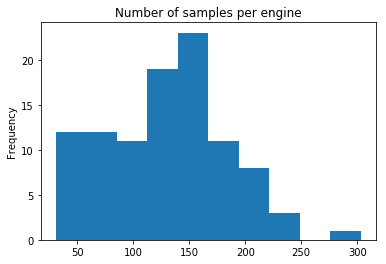

In [8]:
df1.groupby("unit").size().plot(kind="hist")
plt.title("Number of samples per engine")
plt.show()

Let's visualize some sensors for an engine

In [9]:
engine_smpl = df1.loc[df1["unit"] == 56, ["sensor4", "sensor15", "sensor20"]]

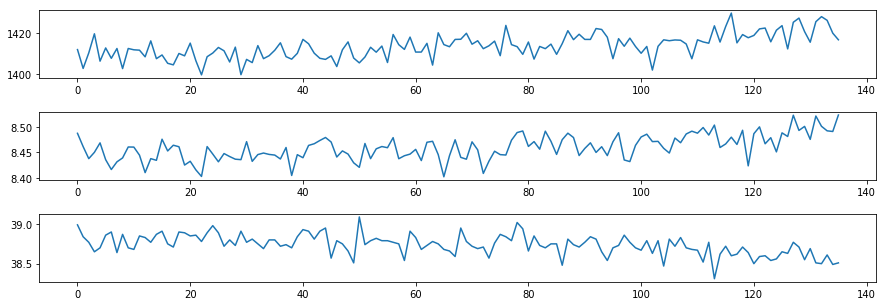

In [10]:
fig = plt.figure(figsize=(15, 5))
grid = plt.GridSpec(3, 1, hspace=0.5)
n = len(engine_smpl)

sensor_a = fig.add_subplot(grid[0, 0])
sensor_b = fig.add_subplot(grid[1, 0])
sensor_c = fig.add_subplot(grid[2, 0])

sensor_a.plot(range(n), engine_smpl["sensor4"])
sensor_b.plot(range(n), engine_smpl["sensor15"])
sensor_c.plot(range(n), engine_smpl["sensor20"])
plt.show()

## Split data into trajectories

Now we'll split the data into 3 parts according to the labeling pattern we decide for each engine so we'll have 300 trajectories. We'll smooth the sensor columns with a moving average window of size 2 in order to remove some noise

In [11]:
sensor_cols = [f"sensor{i}" for i in range(1, 22)]

In [12]:
trajectories = []
for unit in range(1, 101):
    df1_engine = df1[df1["unit"] == unit]
    sensors_smoothed = df1_engine[sensor_cols].rolling(window=2).mean().iloc[1:]
    df1_engine = df1_engine.iloc[1:]
    df1_engine[sensor_cols] = sensors_smoothed
    # making large assumption here about the labels - 
    # healthy occurs the first 40% of the data, attetion for the next 35%, and critical for the last 25%
    df1_engine["label"] = generate_labels(len(df1_engine), 0.4, 0.75)
    for label in range(0, 3):
        df1_engine_label = df1_engine[df1_engine["label"] == label]
        trajectories.append(df1_engine_label)

In [13]:
len(trajectories)

300

Let's take one trajectory to analyze

In [14]:
traj = trajectories[55]

In [15]:
# We'll summarize the time domain using descriptive statistics as features
ts_feats = traj.drop(["unit", "label"], axis=1).describe().iloc[1:]
ts_feats

,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
mean,0.000021,0.000017,100.0,5.186700e+02,642.297340,1585.689574,1400.051064,1.462000e+01,21.609362,554.175851,...,522.139149,2388.044362,8138.508404,8.409194,3.000000e-02,391.638298,2388.0,100.0,38.961277,23.379046
std,0.002471,0.000280,0.0,4.596637e-13,0.213506,2.664143,2.645047,1.795561e-15,0.001687,0.247517,...,0.260729,0.026347,2.470282,0.013470,2.454869e-17,0.528556,0.0,0.0,0.075422,0.043673
min,-0.006700,-0.000400,100.0,5.186700e+02,641.865000,1578.935000,1395.270000,1.462000e+01,21.605000,553.525000,...,521.560000,2387.990000,8133.040000,8.382400,3.000000e-02,390.500000,2388.0,100.0,38.780000,23.250950
25%,-0.001800,-0.000200,100.0,5.186700e+02,642.145000,1583.930000,1398.287500,1.462000e+01,21.610000,554.022500,...,521.987500,2388.025000,8137.185000,8.398325,3.000000e-02,391.500000,2388.0,100.0,38.920000,23.348375
50%,0.000300,0.000000,100.0,5.186700e+02,642.295000,1586.440000,1400.240000,1.462000e+01,21.610000,554.195000,...,522.175000,2388.050000,8138.665000,8.409000,3.000000e-02,391.500000,2388.0,100.0,38.960000,23.375500
75%,0.001650,0.000200,100.0,5.186700e+02,642.410000,1587.910000,1401.440000,1.462000e+01,21.610000,554.372500,...,522.332500,2388.067500,8140.235000,8.418575,3.000000e-02,392.000000,2388.0,100.0,39.000000,23.407125
max,0.005800,0.000600,100.0,5.186700e+02,642.755000,1591.100000,1407.380000,1.462000e+01,21.610000,554.890000,...,522.700000,2388.100000,8145.105000,8.436550,3.000000e-02,392.500000,2388.0,100.0,39.140000,23.488550


In [16]:
ts_feats = ts_feats.values.flatten()

In [17]:
len(ts_feats)

168

## Calculate FFT and DWT

We'll apply the fft to each of the sensors

In [18]:
traj_sensors = traj[sensor_cols]

In [19]:
fft_traj = fftpack.fft(traj_sensors, axis=0)

In [20]:
fft_traj.shape

(47, 21)

Let's analyze one of those sensors more closely

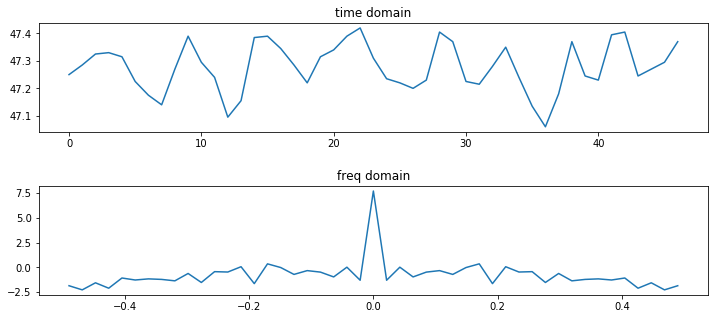

In [21]:
fig = plt.figure(figsize=(12, 5))
grid = plt.GridSpec(2, 1, hspace=0.5)
n = len(traj_sensors)

time_domain = fig.add_subplot(grid[0, 0])
freq_domain = fig.add_subplot(grid[1, 0])

time_domain.plot(range(n), traj_sensors.iloc[:, 10])
time_domain.set_title("time domain")
freq_domain.plot(fftpack.fftshift(fftpack.fftfreq(n)), np.log(np.abs(fftpack.fftshift(fft_traj[:, 10]))))
freq_domain.set_title("freq domain")
plt.show()

We'll find peaks in the fft to use as features. Peaks in the fft correspond to frequencies that are dominant over the signal. We will also calculate the power spectral density (PSD) of those peaks to use as additional features. The power spectral density is simply the magnitude squared of the fourier transform. We'll take the 5 peaks with highest magnitude so that we have a fixed length feature vector for all trajectories. Each peak will have 3 features for it - the location of the peak, the value, and the energy (value squared) leaving us with 15 fourier features for each sensor for each trajectory.

In [22]:
_NUM_FFT_FEATS = 15

In [23]:
def get_fft_cutoff(n):
    # since the fft is conjugate symmetric, we'll just take the first half
    cuttoff = n
    if n % 2 == 0:
        cutoff = n//2 - 1
    else:
        cutoff = (n - 1)//2
    return cutoff + 1

In [24]:
pos, vals = signal.find_peaks(np.abs(fft_traj[:, 10][:get_fft_cutoff(len(fft_traj))]), height=0)

In [25]:
sorted_peaks = sorted(zip(pos, vals["peak_heights"], vals["peak_heights"]**2), key=lambda tup: tup[1], reverse=True)

In [26]:
sorted_peaks

[(8, 1.430427252685029, 2.04612212522404),
 (10, 1.0700879413129283, 1.145088202143341),
 (2, 1.0222949470281808, 1.045086958719351),
 (5, 0.7228700537207613, 0.5225411145662563),
 (12, 0.6504636874222534, 0.4231030086549549),
 (14, 0.5416640695785897, 0.29339996427243925),
 (19, 0.343000633050617, 0.11764943427312402),
 (17, 0.31403831831873674, 0.09862006537246022),
 (21, 0.21138765752602834, 0.044684741754341444)]

In [27]:
fft_psd_peaks = list(itertools.chain(*itertools.islice(sorted_peaks, _NUM_FFT_FEATS//3)))

In [28]:
# pad with -1 to be of length 15 (3 features for each peak) if needed
fft_psd_peaks.extend([-1] * (_NUM_FFT_FEATS - len(fft_psd_peaks)))

In [29]:
fft_psd_peaks

[8,
 1.430427252685029,
 2.04612212522404,
 10,
 1.0700879413129283,
 1.145088202143341,
 2,
 1.0222949470281808,
 1.045086958719351,
 5,
 0.7228700537207613,
 0.5225411145662563,
 12,
 0.6504636874222534,
 0.4231030086549549]

One disadvantage of the fourier transform is that it loses time information so it's not able to localize which frequencies are present at which time instance. Therefore, in addition to fourier features, we'll extract features using the wavelet transform. Wavelets are finite functions and are convolved with the signal at multiple scales. We use a db2 wavelet as recommended for feature detection by [Mathworks](https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html) and for a similar task of [eeg signal classification](https://dl.acm.org/doi/10.1109/JVA.2006.17). The `pywt.dwt` function returns a tuple of arrays. The first array corresponds to the approximations and the second corresponds to the details of the wavelet transform. The approximations are low pass representations of the signal and the details are the dwt coefficients. Filter banks can be built by repeatedly applying the dwt on the approximations using `pywt.wavedec` but we just take the first level. A good reference for wavelet transforms are these [lecture slides](http://people.ciirc.cvut.cz/~hlavac/TeachPresEn/11ImageProc/14WaveletsEn.pdf) by the Czech Technical University.

In [30]:
_NUM_DWT_FEATS = 20

In [31]:
dwt_coeffs = pywt.dwt(traj_sensors.iloc[:, 10], wavelet="db2")[1:]
dwt_feats = np.concatenate(dwt_coeffs)[:_NUM_DWT_FEATS]

In [32]:
if len(dwt_feats) < _NUM_DWT_FEATS:
    dwt_feats = np.pad(dwt_feats, (0, _NUM_DWT_FEATS - len(dwt_feats)), mode="constant", constant_values=-1)

In [33]:
dwt_feats

array([-0.02143304,  0.01625665,  0.03881041, -0.01242082, -0.01652294,
        0.00850453, -0.08736054,  0.08666704,  0.01371492, -0.07662702,
       -0.00301541,  0.070203  , -0.03350711, -0.0235011 ,  0.08265783,
       -0.05096495, -0.01212053,  0.0208789 , -0.09806005,  0.14307465])

Now we'll build our feature vector for all trajectories and all sensors by replicating the steps above in a loop

In [34]:
def find_fft_feats(fft_signal):
    pos, vals = signal.find_peaks(np.abs(fft_signal), height=0)
    sorted_peaks = sorted(zip(pos, vals["peak_heights"], vals["peak_heights"]**2), key=lambda tup: tup[1], reverse=True)
    fft_psd_peaks = list(itertools.chain(*itertools.islice(sorted_peaks, _NUM_FFT_FEATS//3)))
    fft_psd_peaks.extend([-1] * (_NUM_FFT_FEATS - len(fft_psd_peaks)))
    return fft_psd_peaks

In [35]:
def find_dwt_feats(series):
    dwt_feats = pywt.downcoef("d", series, wavelet="db2")[:_NUM_DWT_FEATS]
    if len(dwt_feats) < _NUM_DWT_FEATS:
        dwt_feats = np.pad(dwt_feats, (0, _NUM_DWT_FEATS - len(dwt_feats)), mode="constant", constant_values=-1)
    return dwt_feats

In [36]:
feats = []
labels = []
for traj in trajectories:
    ts_feats = traj.drop(["unit", "label"], axis=1).describe().iloc[1:].values.flatten()
    labels.append(traj.iloc[0,-1])
    traj_sensors = traj[sensor_cols]
    fft_traj = fftpack.fft(traj_sensors, axis=0)
    fft_cutoff = get_fft_cutoff(len(fft_traj))
    fft_dwt_feats = []
    for i in range(len(sensor_cols)):
        fft_feats = find_fft_feats(fft_traj[:, i][:fft_cutoff])
        dwt_feats = find_dwt_feats(traj_sensors.iloc[:, i])
        fft_dwt_feats.append(np.concatenate([fft_feats, dwt_feats]))
    feats.append(np.concatenate([ts_feats, np.concatenate(fft_dwt_feats)]))

In [37]:
df_feats = pd.DataFrame(feats)

In [38]:
# make sure we don't have any features that are all -1 that we can drop. -1 is the padding value we used above
np.where((df_feats == -1).all(axis=0))

(array([], dtype=int64),)

In [39]:
all_feats = np.stack(feats)

In [40]:
labels = np.zeros(len(trajectories), dtype="uint8")
for i, traj in enumerate(trajectories):
    labels[i] = traj.iloc[0,-1]

We have a relatively small but high dimensional numerical dataset so an SVM seems suitable for modeling this task. In order to assure that features with high numerical values don't overpower ones with lower values while defining a hyperplane, we scale the data to have unit variance and zero mean. We use 5-fold cross validation in order to validate our model and be more confident in its performance and make sure we're not overfitting. We track accuracy as an appropriate performance metric since our dataset is balanced and only has a few classes.

In [41]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [42]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [43]:
for train_index, test_index in skf.split(all_feats, labels):
    X_train, X_test = all_feats[train_index], all_feats[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    scaler = StandardScaler()
    clf = SVC(C=0.9, kernel="rbf")
    X_train_scl = scaler.fit_transform(X_train)
    clf.fit(X_train_scl, y_train)
    X_test_scl = scaler.transform(X_test)
    print(f"Train accuracy: {clf.score(X_train_scl, y_train)}, test accuracy: {clf.score(X_test_scl, y_test)}")

Train accuracy: 0.9208333333333333, test accuracy: 0.7833333333333333
Train accuracy: 0.8916666666666667, test accuracy: 0.7
Train accuracy: 0.9208333333333333, test accuracy: 0.8
Train accuracy: 0.9083333333333333, test accuracy: 0.8
Train accuracy: 0.9125, test accuracy: 0.8333333333333334


We are able to achieve ~90% accuracy on the training data and ~80% accuracy on the validation data without much hyperparameter tuning. In the real world we'd want to be more careful about choosing our decision boundary and probably give a higher penalty to the case where we don't predict the critical state when it should have been predicted if the goal is to prevent failures from occurring. The focus of this exercise was more focused on how we can extract features using the fft and dwt and build a simple sklearn classifier rather than actually tuning an SVM classifier - since there are plenty of tutorials on that. Feedback in the form of github issues or PRs is always welcome!